# Predicting Water Pump Functionality in Tanzania (HydroLogic Project)
Authored by Farzaneh Gerami, Subaye Opoku-Acquah & Mariam Farda | 
March – June 2025

# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway

import math

import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import joblib


# Sprint 1 - Data Cleaning and Preprocessing

## Read Merged Data

In [2]:
# Read Merged data as an original data
url_merge_data = "../data/processed/Merged_Training_Set.csv"
df_train_original = pd.read_csv(url_merge_data)

In [3]:
# make a copy of the original dataset
df_train_cleaned = df_train_original.copy()
df_train_cleaned

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


## Feature Summary

In [4]:
# Basic summary statics
def feature_summary(df):
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Zero Values': (df == 0).sum(),
        'Unique Values': df.nunique()
    })
    # Add Percent of Missing Values
    summary['% Missing'] = (summary['Missing Values'] / len(df)) * 100
    
    # Classify Feature Type
    def classify_feature(col):
        if df[col].dtype == 'object':
            return 'Categorical'
        elif df[col].dtype in ['int64', 'float64']:
            if df[col].nunique() < 15:
                return 'Ordinal/Categorical'
            return 'Numerical'
        elif df[col].dtype == 'bool':
            return 'Boolean'
        elif 'date' in col:
            return 'Date'
        else:
            return 'Other'
    # Applies the classifier to each column.
    summary['Feature Type'] = summary.index.to_series().apply(classify_feature)
    return summary.sort_values(by='Missing Values', ascending=False)

# Run the summary
feature_summary(df_train_cleaned)


,Data Type,Missing Values,Zero Values,Unique Values,% Missing,Feature Type
scheme_name,object,28166,0,2696,47.417508,Categorical
scheme_management,object,3877,0,12,6.526936,Categorical
installer,object,3655,0,2145,6.153199,Categorical
funder,object,3635,0,1897,6.119529,Categorical
public_meeting,object,3334,5055,2,5.612795,Categorical
permit,object,3056,17492,2,5.144781,Categorical
subvillage,object,371,0,19287,0.624579,Categorical
payment,object,0,0,7,0.000000,Categorical
waterpoint_type_group,object,0,0,6,0.000000,Categorical
extraction_type_group,object,0,0,13,0.000000,Categorical


# Convert Categorical Variables to Appropriate Formats

In [5]:
# view unique values
for col in df_train_cleaned.columns:
    print(f"--- {col} ---")
    print(df_train_cleaned[col].unique())
    print()

--- id ---
[69572  8776 34310 ... 37057 31282 26348]

--- amount_tsh ---
[6.00e+03 0.00e+00 2.50e+01 2.00e+01 2.00e+02 5.00e+02 5.00e+01 4.00e+03
 1.50e+03 6.00e+00 2.50e+02 1.00e+01 1.00e+03 1.00e+02 3.00e+01 2.00e+03
 4.00e+02 1.20e+03 4.00e+01 3.00e+02 2.50e+04 7.50e+02 5.00e+03 6.00e+02
 7.20e+03 2.40e+03 5.00e+00 3.60e+03 4.50e+02 4.00e+04 1.20e+04 3.00e+03
 7.00e+00 2.00e+04 2.80e+03 2.20e+03 7.00e+01 5.50e+03 1.00e+04 2.50e+03
 6.50e+03 5.50e+02 3.30e+01 8.00e+03 4.70e+03 7.00e+03 1.40e+04 1.30e+03
 1.00e+05 7.00e+02 1.00e+00 6.00e+01 3.50e+02 2.00e-01 3.50e+01 3.06e+02
 8.50e+03 1.17e+05 3.50e+03 5.20e+02 1.50e+01 6.30e+03 9.00e+03 1.50e+02
 1.20e+05 1.38e+05 3.50e+05 4.50e+03 1.30e+04 4.50e+04 2.00e+00 1.50e+04
 1.10e+04 5.00e+04 7.50e+03 1.63e+04 8.00e+02 1.60e+04 3.00e+04 5.30e+01
 5.40e+03 7.00e+04 2.50e+05 2.00e+05 2.60e+04 1.80e+04 2.60e+01 5.90e+02
 9.00e+02 9.00e+00 1.40e+03 1.70e+05 2.20e+02 3.80e+04 2.50e-01 1.20e+01
 6.00e+04 5.90e+01]

--- date_recorded ---
['2011-0

In [6]:
# just quick check what is inside the columns
print(df_train_cleaned['public_meeting'].unique())
print(df_train_cleaned['permit'].unique())

print(df_train_cleaned['construction_year'].unique())
print(df_train_cleaned['date_recorded'].unique())

# this is a categorical geographic region and has 9 unique values
print(df_train_cleaned['basin'].unique())
# it may not be useful for modeling but as it has only 1 unique value i changed it to category
print(df_train_cleaned['recorded_by'].unique())
# this column has 11 unique values making it ideal for categorical encoding later
print(df_train_cleaned['scheme_management'].unique())

[True nan False]
[False True nan]
[1999 2010 2009 1986    0 2011 1987 1991 1978 1992 2008 1974 2000 2002
 2004 1972 2003 1980 2007 1973 1985 1970 1995 2006 1962 2005 1997 2012
 1996 1977 1983 1984 1990 1982 1976 1988 1989 1975 1960 1961 1998 1963
 1971 1994 1968 1993 2001 1979 1967 2013 1969 1981 1964 1966 1965]
['2011-03-14' '2013-03-06' '2013-02-25' '2013-01-28' '2011-07-13'
 '2011-03-13' '2012-10-01' '2012-10-09' '2012-11-03' '2011-08-03'
 '2011-02-20' '2013-02-18' '2012-10-14' '2013-03-15' '2012-10-20'
 '2011-08-04' '2011-07-04' '2011-09-04' '2011-07-22' '2011-02-22'
 '2011-02-27' '2013-02-10' '2011-10-04' '2013-11-03' '2013-01-21'
 '2013-01-16' '2011-07-11' '2013-03-05' '2013-03-16' '2011-03-23'
 '2011-03-16' '2013-03-19' '2011-03-11' '2011-02-23' '2013-03-28'
 '2011-07-16' '2011-03-27' '2013-02-11' '2013-10-03' '2011-03-12'
 '2011-07-07' '2013-01-15' '2013-03-18' '2012-10-22' '2013-02-05'
 '2011-07-27' '2011-04-04' '2013-02-21' '2011-08-18' '2011-07-31'
 '2011-08-01' '2011-07-14'

In [7]:
# Clean and Convert public_meeting
# Convert to string, clean casing and spaces, then map to booleans
df_train_cleaned['public_meeting'] = df_train_cleaned['public_meeting'].astype(str).str.strip().str.lower()
df_train_cleaned['public_meeting'] = df_train_cleaned['public_meeting'].map({'true': True, 'false': False})
df_train_cleaned['public_meeting'] = df_train_cleaned['public_meeting'].astype('boolean')

In [8]:
# Clean and Convert permit
df_train_cleaned['permit'] = df_train_cleaned['permit'].astype(str).str.strip().str.lower()
df_train_cleaned['permit'] = df_train_cleaned['permit'].map({'true': True, 'false': False})
df_train_cleaned['permit'] = df_train_cleaned['permit'].astype('boolean')

In [9]:
# Convert date_recorded to datetime
df_train_cleaned['date_recorded'] = pd.to_datetime(df_train_cleaned['date_recorded'], errors='coerce')

In [10]:
# Clean and Convert construction_year to datetime
# Remove years that are likely invalid (e.g., 0 or <1900)
df_train_cleaned.loc[df_train_cleaned['construction_year'] < 1900, 'construction_year'] = pd.NA

# Convert the year into a full datetime format (assumes Jan 1 of each year)
df_train_cleaned['construction_year'] = pd.to_datetime(
    df_train_cleaned['construction_year'], format='%Y', errors='coerce'
)


In [11]:
# Strip whitespace and lower the casing
df_train_cleaned['basin'] = df_train_cleaned['basin'].astype(str).str.strip().str.lower()
df_train_cleaned['recorded_by'] = df_train_cleaned['recorded_by'].astype(str).str.strip().str.lower()
df_train_cleaned['scheme_management'] = df_train_cleaned['scheme_management'].astype(str).str.strip().str.lower()

In [12]:
# covert to category
df_train_cleaned['basin'] = df_train_cleaned['basin'].astype('category')
df_train_cleaned['recorded_by'] = df_train_cleaned['recorded_by'].astype('category')
df_train_cleaned['scheme_management'] = df_train_cleaned['scheme_management'].astype('category')

## Check the Data Type

In [13]:
# Check Data Types
print(df_train_cleaned[['public_meeting', 'permit', 'date_recorded', 'construction_year', 'basin', 'recorded_by', 'scheme_management']].dtypes)

public_meeting              boolean
permit                      boolean
date_recorded        datetime64[ns]
construction_year    datetime64[ns]
basin                      category
recorded_by                category
scheme_management          category
dtype: object


In [14]:
# Inspect Unique Values Again
print(df_train_cleaned['public_meeting'].unique())
print(df_train_cleaned['permit'].unique())
print(df_train_cleaned['construction_year'].unique())
print(df_train_cleaned['date_recorded'].unique())
print(df_train_cleaned['basin'].unique())
print(df_train_cleaned['recorded_by'].unique())
print(df_train_cleaned['scheme_management'].unique())


<BooleanArray>
[True, <NA>, False]
Length: 3, dtype: boolean
<BooleanArray>
[False, True, <NA>]
Length: 3, dtype: boolean
['1999-01-01T00:00:00.000000000' '2010-01-01T00:00:00.000000000'
 '2009-01-01T00:00:00.000000000' '1986-01-01T00:00:00.000000000'
                           'NaT' '2011-01-01T00:00:00.000000000'
 '1987-01-01T00:00:00.000000000' '1991-01-01T00:00:00.000000000'
 '1978-01-01T00:00:00.000000000' '1992-01-01T00:00:00.000000000'
 '2008-01-01T00:00:00.000000000' '1974-01-01T00:00:00.000000000'
 '2000-01-01T00:00:00.000000000' '2002-01-01T00:00:00.000000000'
 '2004-01-01T00:00:00.000000000' '1972-01-01T00:00:00.000000000'
 '2003-01-01T00:00:00.000000000' '1980-01-01T00:00:00.000000000'
 '2007-01-01T00:00:00.000000000' '1973-01-01T00:00:00.000000000'
 '1985-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1995-01-01T00:00:00.000000000' '2006-01-01T00:00:00.000000000'
 '1962-01-01T00:00:00.000000000' '2005-01-01T00:00:00.000000000'
 '1997-01-01T00:00:00.000000000' 

In [15]:
# Check for Nulls
print("\nMissing values:")
print(df_train_cleaned.isnull().sum().sort_values(ascending=False).head(10))


Missing values:
scheme_name              28166
construction_year        20709
installer                 3655
funder                    3635
public_meeting            3334
permit                    3056
subvillage                 371
payment_type                 0
extraction_type_group        0
extraction_type_class        0
dtype: int64


In [16]:
# showing the categorical columns
categorical_col = df_train_cleaned.select_dtypes(include=['object', 'category', 'boolean']).columns
missing_info = pd.DataFrame({
    'Data Type': df_train_cleaned[categorical_col].dtypes,
    'Missing %': (df_train_cleaned[categorical_col].isnull().mean()*100)
})
missing_info = missing_info.sort_values(by= 'Missing %', ascending=False)
print(missing_info)

                      Data Type  Missing %
scheme_name              object  47.417508
installer                object   6.153199
funder                   object   6.119529
public_meeting          boolean   5.612795
permit                  boolean   5.144781
subvillage               object   0.624579
source_class             object   0.000000
source_type              object   0.000000
source                   object   0.000000
payment                  object   0.000000
quantity_group           object   0.000000
quantity                 object   0.000000
waterpoint_type          object   0.000000
quality_group            object   0.000000
water_quality            object   0.000000
waterpoint_type_group    object   0.000000
payment_type             object   0.000000
extraction_type_class    object   0.000000
management_group         object   0.000000
management               object   0.000000
extraction_type_group    object   0.000000
extraction_type          object   0.000000
scheme_mana

## Impute Missing Values

## Checking for duplication

In [17]:
# to check duplication between the quantity and quantity group
df_train_cleaned['quantity_match'] = df_train_cleaned['quantity'] == df_train_cleaned['quantity_group']

match_counts = df_train_cleaned['quantity_match'].value_counts()
print(match_counts)

True    59400
Name: quantity_match, dtype: int64


In [18]:
mismatches = df_train_cleaned[df_train_cleaned['quantity_match'] == False][['quantity', 'quantity_group']]
print(mismatches.head())

Empty DataFrame
Columns: [quantity, quantity_group]
Index: []


In [19]:
match_rate = df_train_cleaned['quantity_match'].mean() * 100
print(f"Match Rate: {match_rate:.2f}%")

Match Rate: 100.00%


Yes, they are both similar and i drop the quantity_group

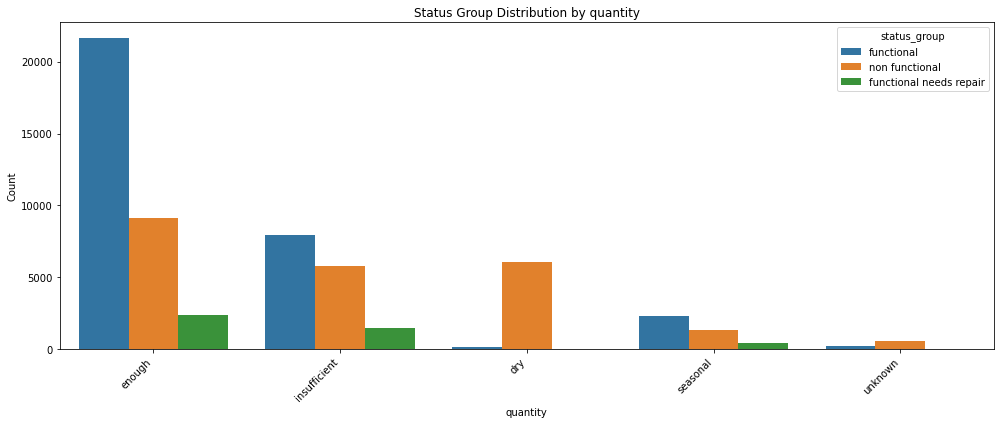

In [20]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='quantity', hue='status_group')
plt.title("Status Group Distribution by quantity")
plt.xticks(rotation=45, ha='right')
plt.xlabel("quantity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

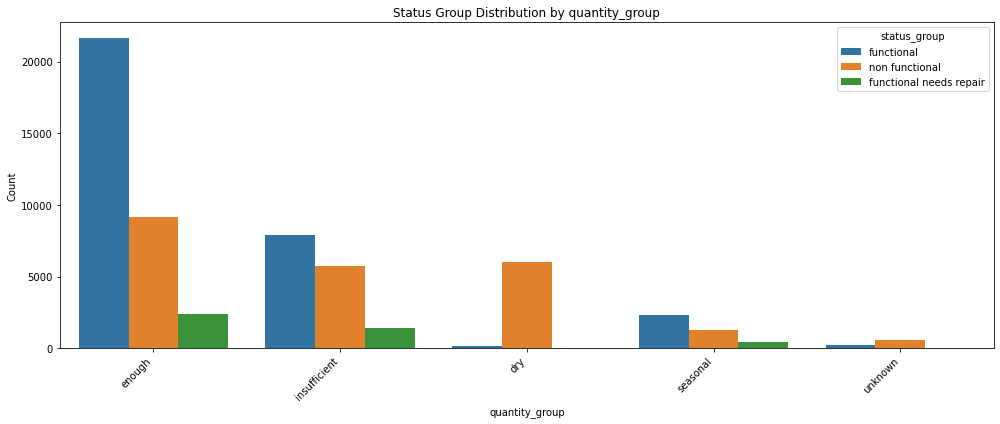

In [21]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='quantity_group', hue='status_group')
plt.title("Status Group Distribution by quantity_group")
plt.xticks(rotation=45, ha='right')
plt.xlabel("quantity_group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [22]:
# looks for the mismatch between extraction_type and extraction_type_group
mismatched = df_train_cleaned[df_train_cleaned['extraction_type'] != df_train_cleaned['extraction_type_group']]
# Show a few rows where they differ
mismatched[['extraction_type', 'extraction_type_group']].head(10)

,extraction_type,extraction_type_group
31,ksb,submersible
45,windmill,wind-powered
66,other - rope pump,rope pump
88,ksb,submersible
92,ksb,submersible
96,ksb,submersible
147,other - rope pump,rope pump
155,other - swn 81,other handpump
172,ksb,submersible
193,ksb,submersible


In [23]:
# Count how often each mismatch occurs
mismatch_summary = mismatched.groupby(['extraction_type', 'extraction_type_group']).size().reset_index(name='count')
print(mismatch_summary.sort_values(by='count', ascending=False))


             extraction_type extraction_type_group  count
2                        ksb           submersible   1415
5          other - rope pump             rope pump    451
6             other - swn 81        other handpump    229
8                   windmill          wind-powered    117
0                       cemo       other motorpump     90
4          other - play pump        other handpump     85
7                     walimi        other handpump     48
1                     climax       other motorpump     32
3  other - mkulima/shinyanga        other handpump      2


In [24]:
matched = df_train_cleaned[df_train_cleaned['extraction_type'] == df_train_cleaned['extraction_type_group']]
# Show a few rows where they differ
mismatched[['extraction_type', 'extraction_type_group']].head(10)

,extraction_type,extraction_type_group
31,ksb,submersible
45,windmill,wind-powered
66,other - rope pump,rope pump
88,ksb,submersible
92,ksb,submersible
96,ksb,submersible
147,other - rope pump,rope pump
155,other - swn 81,other handpump
172,ksb,submersible
193,ksb,submersible


In [25]:
# Count how often each mismatch occurs
match_summary = matched.groupby(['extraction_type', 'extraction_type_group']).size().reset_index(name='count')
print(match_summary.sort_values(by='count', ascending=False))


  extraction_type extraction_type_group  count
1         gravity               gravity  26780
5     nira/tanira           nira/tanira   8154
6           other                 other   6430
7     submersible           submersible   4764
8          swn 80                swn 80   3670
4            mono                  mono   2865
2   india mark ii         india mark ii   2400
0         afridev               afridev   1770
3  india mark iii        india mark iii     98


My conclusion is that i can drop this column as it is so similar to eachother but the extraction_type_group is with less detailed. The same i observe for the waterpoint_type and waterpoint_type_group, and i decided to keep the waterpoint_type_group. 

In [26]:
# duplicate between 'extraction_type', 'extraction_type_group', 'extraction_type_class'
columns = ['extraction_type', 'extraction_type_group', 'extraction_type_class']

for col in columns:
    print(f"\n {col} — Unique Values and Frequencies:\n{'-'*50}")
    
    # Get value counts (number and percent)
    counts = df_train_cleaned[col].value_counts(dropna=False)
    percentages = df_train_cleaned[col].value_counts(normalize=True, dropna=False) * 100

    # Combine into a single DataFrame
    summary = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(2)
    })
    
    # Print top values
    print(summary.head(10))  # You can change this to `.to_string()` to see all



 extraction_type — Unique Values and Frequencies:
--------------------------------------------------
                   Count  Percentage
gravity            26780       45.08
nira/tanira         8154       13.73
other               6430       10.82
submersible         4764        8.02
swn 80              3670        6.18
mono                2865        4.82
india mark ii       2400        4.04
afridev             1770        2.98
ksb                 1415        2.38
other - rope pump    451        0.76

 extraction_type_group — Unique Values and Frequencies:
--------------------------------------------------
                Count  Percentage
gravity         26780       45.08
nira/tanira      8154       13.73
other            6430       10.82
submersible      6179       10.40
swn 80           3670        6.18
mono             2865        4.82
india mark ii    2400        4.04
afridev          1770        2.98
rope pump         451        0.76
other handpump    364        0.61

 extract

In [27]:
# Create a column to flag mismatches
df_train_cleaned['extraction_mismatch'] = ~(
    (df_train_cleaned['extraction_type'] == df_train_cleaned['extraction_type_group']) &
    (df_train_cleaned['extraction_type'] == df_train_cleaned['extraction_type_class']) &
    (df_train_cleaned['extraction_type_group'] == df_train_cleaned['extraction_type_class'])
)

#Filter mismatched rows
mismatches = df_train_cleaned[df_train_cleaned['extraction_mismatch']][[
    'extraction_type', 'extraction_type_group', 'extraction_type_class'
]]

#Summarize mismatch patterns
mismatch_summary = mismatches.groupby([
    'extraction_type', 'extraction_type_group', 'extraction_type_class'
]).size().reset_index(name='count').sort_values(by='count', ascending=False)

# print top 10 mismatch patterns
print(mismatch_summary.head(10))


      extraction_type extraction_type_group extraction_type_class  count
7         nira/tanira           nira/tanira              handpump   8154
12             swn 80                swn 80              handpump   3670
6                mono                  mono             motorpump   2865
3       india mark ii         india mark ii              handpump   2400
0             afridev               afridev              handpump   1770
5                 ksb           submersible           submersible   1415
10  other - rope pump             rope pump             rope pump    451
11     other - swn 81        other handpump              handpump    229
14           windmill          wind-powered          wind-powered    117
4      india mark iii        india mark iii              handpump     98


So i decided to keep the less details classification. Later we need to check if there is any relation between the extraction_type_class and the target

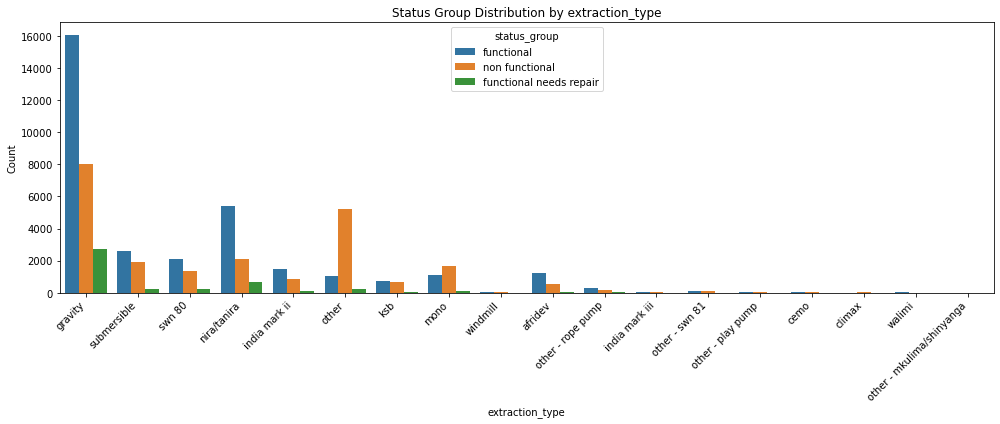

In [28]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='extraction_type', hue='status_group')
plt.title("Status Group Distribution by extraction_type")
plt.xticks(rotation=45, ha='right')
plt.xlabel("extraction_type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

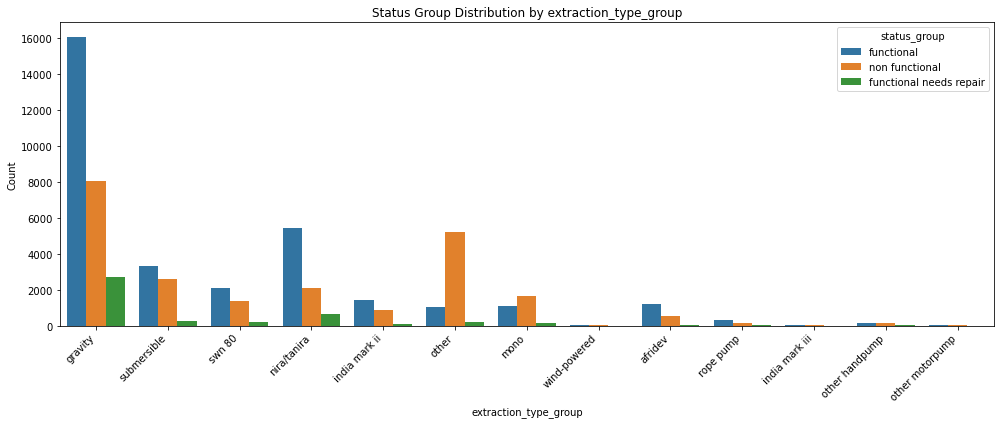

In [29]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='extraction_type_group', hue='status_group')
plt.title("Status Group Distribution by extraction_type_group")
plt.xticks(rotation=45, ha='right')
plt.xlabel("extraction_type_group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

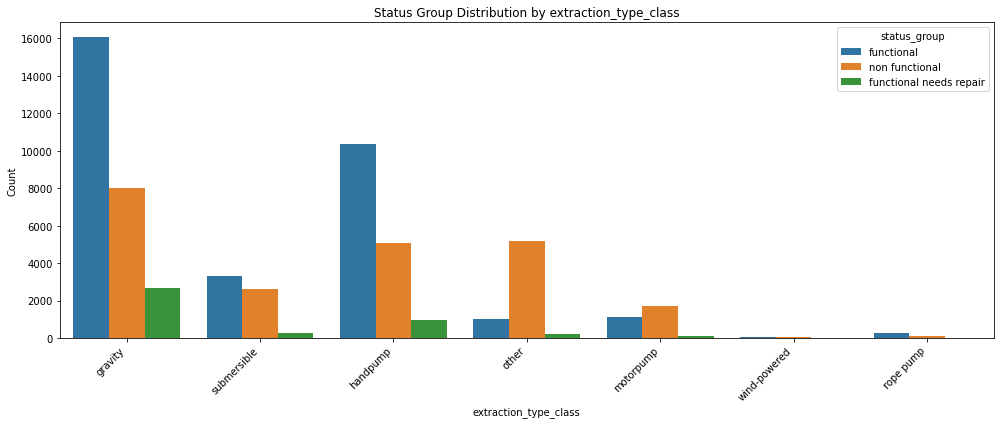

In [30]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='extraction_type_class', hue='status_group')
plt.title("Status Group Distribution by extraction_type_class")
plt.xticks(rotation=45, ha='right')
plt.xlabel("extraction_type_class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [31]:
# Calculate row-wise match
match_mask = df_train_cleaned['waterpoint_type'] == df_train_cleaned['waterpoint_type_group']

# Percentage of exact matches
match_percentage = match_mask.mean() * 100
print(f"Match Rate: {match_percentage:.2f}%")

# Count of matching vs mismatching rows
match_counts = match_mask.value_counts()
print("\nMatch vs Mismatch Counts:")
print(match_counts)

# show mismatched combinations
mismatches = df_train_cleaned[~match_mask][['waterpoint_type', 'waterpoint_type_group']]
mismatch_summary = mismatches.groupby(
    ['waterpoint_type', 'waterpoint_type_group']
).size().reset_index(name='count').sort_values(by='count', ascending=False)

print("\nTop Mismatch Patterns:")
print(mismatch_summary.head(10))


Match Rate: 89.73%

Match vs Mismatch Counts:
True     53297
False     6103
dtype: int64

Top Mismatch Patterns:
               waterpoint_type waterpoint_type_group  count
0  communal standpipe multiple    communal standpipe   6103


In [32]:
# Count how often each mismatch occurs
mismatch_summary = mismatched.groupby(['waterpoint_type', 'waterpoint_type_group']).size().reset_index(name='count')
print(mismatch_summary.sort_values(by='count', ascending=False))


               waterpoint_type waterpoint_type_group  count
1           communal standpipe    communal standpipe   1293
4                    hand pump             hand pump    713
2  communal standpipe multiple    communal standpipe    389
5                        other                 other     70
0                cattle trough         cattle trough      3
3                          dam                   dam      1


interpretation: they are almost similar. in waterpoint_type there is one type communal standpoint multiple that it is changed to communal standpipe in the other. So i prefer to keep the waterpoint_type maybe this multiple type has any impact on functionality of pupm.

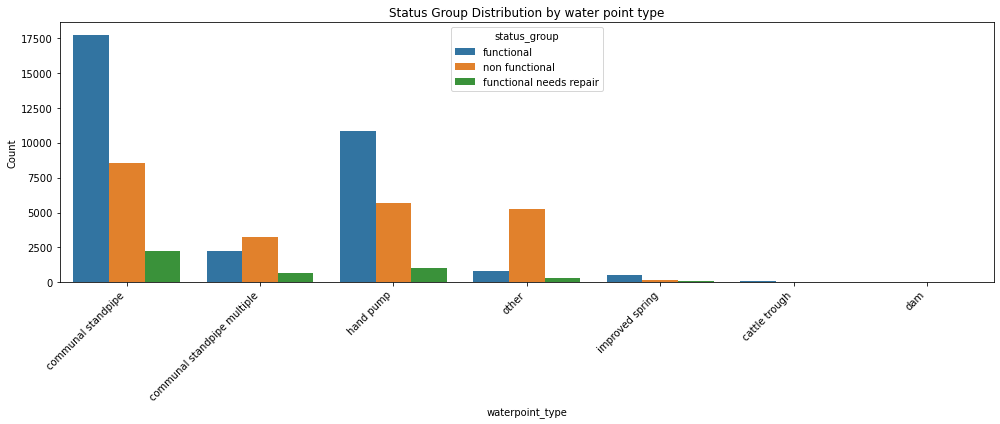

In [33]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='waterpoint_type', hue='status_group')
plt.title("Status Group Distribution by water point type")
plt.xticks(rotation=45, ha='right')
plt.xlabel("waterpoint_type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

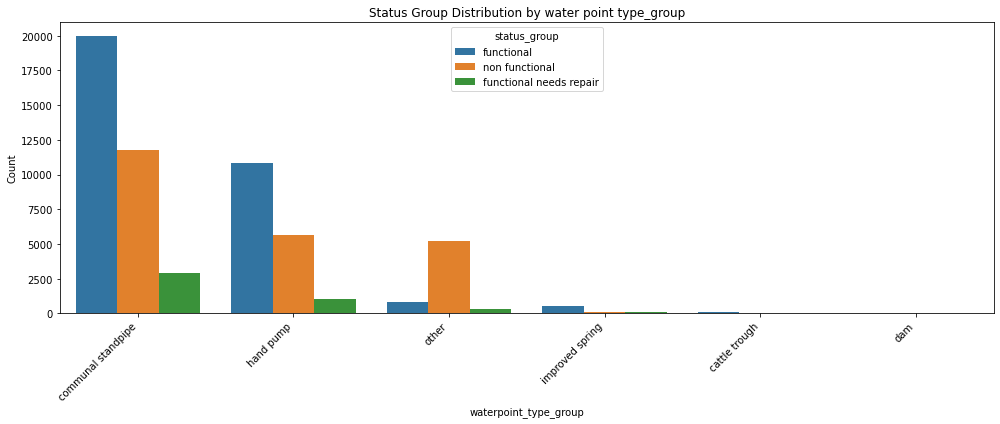

In [34]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='waterpoint_type_group', hue='status_group')
plt.title("Status Group Distribution by water point type_group")
plt.xticks(rotation=45, ha='right')
plt.xlabel("waterpoint_type_group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [35]:
# Count how often each mismatch occurs
mismatch_summary = mismatched.groupby(['source', 'source_type']).size().reset_index(name='count')
print(mismatch_summary.sort_values(by='count', ascending=False))


                 source           source_type  count
6                 river            river/lake    833
3           machine dbh              borehole    544
7          shallow well          shallow well    384
8                spring                spring    196
0                   dam                   dam    181
2                  lake            river/lake    143
1              hand dtw              borehole    118
5  rainwater harvesting  rainwater harvesting     63
4                 other                 other      4
9               unknown                 other      3


In [36]:
# Check for exact matches
match_mask = df_train_cleaned['source'] == df_train_cleaned['source_type']
match_percentage = match_mask.mean() * 100
print(f" Match Rate between 'source' and 'source_type': {match_percentage:.2f}%")

 Match Rate between 'source' and 'source_type': 62.30%


In [37]:
# View mismatch patterns
mismatches = df_train_cleaned[~match_mask][['source', 'source_type']]
mismatch_summary = mismatches.groupby(['source', 'source_type']).size().reset_index(name='count')
print("\nTop mismatches:")
print(mismatch_summary.sort_values(by='count', ascending=False).head(10))


Top mismatches:
        source source_type  count
2  machine dbh    borehole  11075
3        river  river/lake   9612
0     hand dtw    borehole    874
1         lake  river/lake    765
4      unknown       other     66


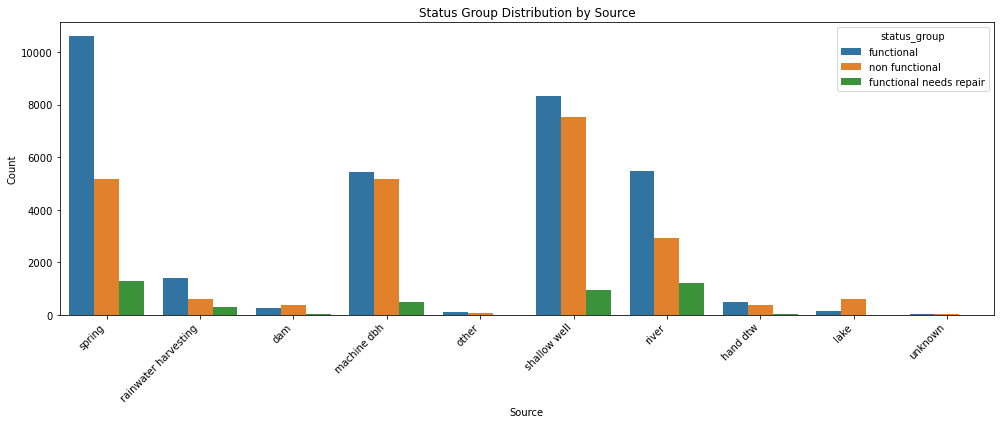

In [38]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='source', hue='status_group')
plt.title("Status Group Distribution by Source")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Source")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

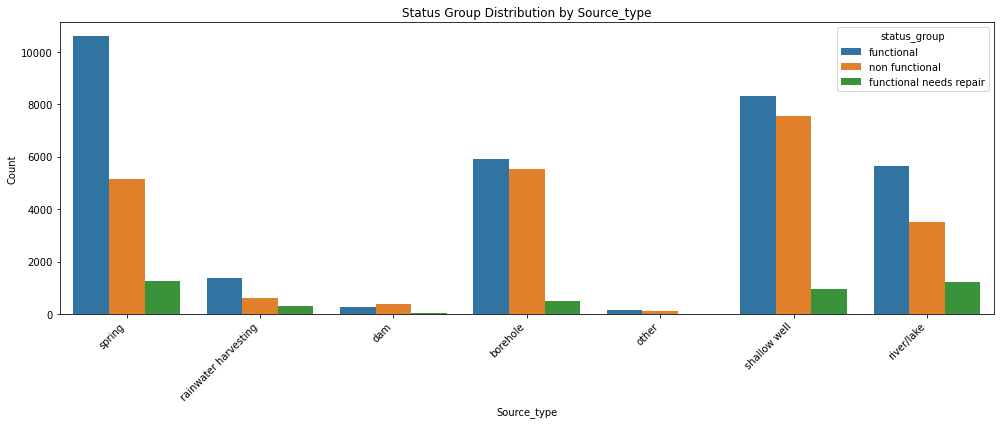

In [39]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_train_cleaned, x='source_type', hue='status_group')
plt.title("Status Group Distribution by Source_type")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Source_type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Interpretation: I think i will keep the source type and delete the source. They are similar and the relation between them and the status group also is similar. 

In [40]:
# Check for exact matches
match_mask = df_train_cleaned['payment'] == df_train_cleaned['payment_type']
match_percentage = match_mask.mean() * 100
print(f" Match Rate between 'payment' and 'payment_type': {match_percentage:.2f}%")

 Match Rate between 'payment' and 'payment_type': 58.18%


In [41]:
# View mismatch patterns
mismatches = df_train_cleaned[~match_mask][['payment', 'payment_type']]
mismatch_summary = mismatches.groupby(['payment', 'payment_type']).size().reset_index(name='count')
print("\nTop mismatches:")
print(mismatch_summary.sort_values(by='count', ascending=False).head(10))


Top mismatches:
                 payment payment_type  count
2         pay per bucket   per bucket   8985
1            pay monthly      monthly   8300
3  pay when scheme fails   on failure   3914
0           pay annually     annually   3642


Interpretation: payment and payment_type are similar better to drop payment as the classification topic is better in payment_type.

## Drop columns

In [42]:
# Drop some column
columns_to_drop = ['recorded_by', 'id', 'num_private', 'quantity_group', 'extraction_type', 'extraction_type_group','waterpoint_type_group', 'source', 'payment']
df_train_cleaned.drop(columns = columns_to_drop, inplace = True)
print('droped successfuly!')

droped successfuly!


In [43]:
df_train_cleaned.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type,status_group,quantity_match,extraction_mismatch
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,lake nyasa,Mnyusi B,...,annually,soft,good,enough,spring,groundwater,communal standpipe,functional,True,False
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,lake victoria,Nyamara,...,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,True,False
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,pangani,Majengo,...,per bucket,soft,good,enough,dam,surface,communal standpipe multiple,functional,True,False
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,ruvuma / southern coast,Mahakamani,...,never pay,soft,good,dry,borehole,groundwater,communal standpipe multiple,non functional,True,False
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,lake victoria,Kyanyamisa,...,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,True,False


# Analyze Cardinality of Categorical Features

In [44]:
# Summary of categorical columns
cat_summary = df_train_cleaned.select_dtypes(include='object').nunique().sort_values(ascending=False)
print(cat_summary)


wpt_name                 37400
subvillage               19287
scheme_name               2696
installer                 2145
ward                      2092
funder                    1897
lga                        125
region                      21
management                  12
water_quality                8
extraction_type_class        7
payment_type                 7
source_type                  7
waterpoint_type              7
quality_group                6
management_group             5
quantity                     5
source_class                 3
status_group                 3
dtype: int64


# Categorize them as low or high cardinality

In [45]:
# Recalculate high cardinality columns
high_card_cols = cat_summary[cat_summary > 10].index.tolist()
high_card_cols

['wpt_name',
 'subvillage',
 'scheme_name',
 'installer',
 'ward',
 'funder',
 'lga',
 'region',
 'management']

In [46]:
# Select low cardinality columns (2–10 unique values)
low_card_cols = cat_summary[(cat_summary <= 10) & (cat_summary > 1)].index.tolist()
low_card_cols

['water_quality',
 'extraction_type_class',
 'payment_type',
 'source_type',
 'waterpoint_type',
 'quality_group',
 'management_group',
 'quantity',
 'source_class',
 'status_group']

## Implement Encoding

## One-Hot Encode Low Cardinality Columns

In [47]:
# Apply One-Hot Encode Low Cardinality
df_encoded = pd.get_dummies(df_train_cleaned, columns=low_card_cols, drop_first=True)

# Preview result
print(f"Total new shape: {df_train_cleaned.shape}")
print("First few column names:", df_train_cleaned.columns[:10].tolist())

Total new shape: (59400, 34)
First few column names: ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage']


## Frequency Encode High Cardinality Columns

In [48]:
# Apply frequency encoding
for col in high_card_cols:
    freq_map = df_train_cleaned[col].value_counts().to_dict()
    df_train_cleaned[col + '_freq'] = df_train_cleaned[col].map(freq_map)

In [49]:
# Check result
print("Final encoded shape:", df_train_cleaned)
df_train_cleaned.head()

Final encoded shape:        amount_tsh date_recorded           funder  gps_height     installer  \
0          6000.0    2011-03-14            Roman        1390         Roman   
1             0.0    2013-03-06          Grumeti        1399       GRUMETI   
2            25.0    2013-02-25     Lottery Club         686  World vision   
3             0.0    2013-01-28           Unicef         263        UNICEF   
4             0.0    2011-07-13      Action In A           0       Artisan   
...           ...           ...              ...         ...           ...   
59395        10.0    2013-05-03  Germany Republi        1210           CES   
59396      4700.0    2011-05-07      Cefa-njombe        1212          Cefa   
59397         0.0    2011-04-11              NaN           0           NaN   
59398         0.0    2011-03-08            Malec           0          Musa   
59399         0.0    2011-03-23       World Bank         191         World   

       longitude   latitude              w

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,extraction_mismatch,wpt_name_freq,subvillage_freq,scheme_name_freq,installer_freq,ward_freq,funder_freq,lga_freq,region_freq,management_freq
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,lake nyasa,Mnyusi B,...,False,3563,6.0,139.0,94.0,36,275.0,564,5294,40507
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,lake victoria,Nyamara,...,False,830,5.0,NaN,39.0,71,53.0,716,1969,6515
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,pangani,Majengo,...,False,3,502.0,9.0,408.0,10,8.0,308,1583,40507
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,ruvuma / southern coast,Mahakamani,...,False,1,17.0,NaN,222.0,32,1057.0,158,1730,40507
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,lake victoria,Kyanyamisa,...,False,1748,2.0,NaN,135.0,13,1.0,771,3316,844


# Check for and Handle Outliers in Numerical Features

## Identify Numerical Columns

In [50]:
# Get numeric columns, but exclude ID or code-like columns
numeric_cols = df_train_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
excluded = ['region_code', 'district_code']  # Don't plot these
numeric_cols = [col for col in numeric_cols if col not in excluded]
numeric_cols

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'wpt_name_freq',
 'subvillage_freq',
 'scheme_name_freq',
 'installer_freq',
 'ward_freq',
 'funder_freq',
 'lga_freq',
 'region_freq',
 'management_freq']

# Visualize Distributions

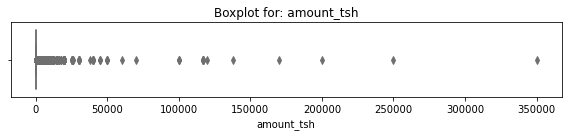

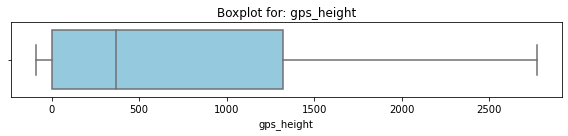

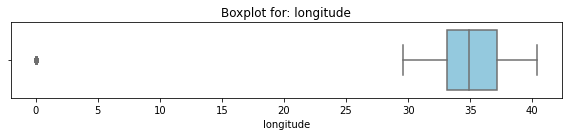

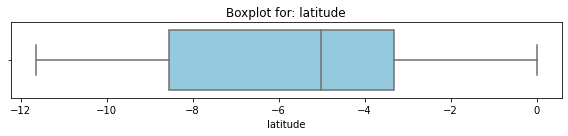

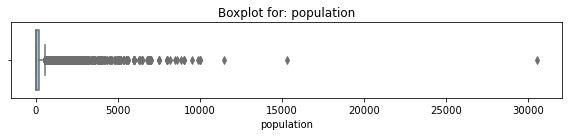

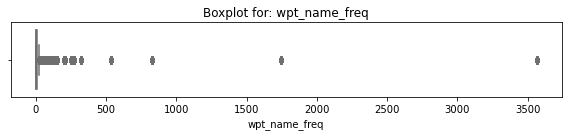

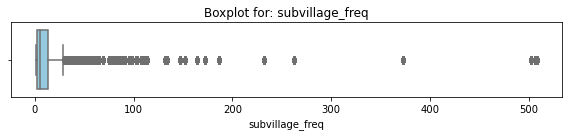

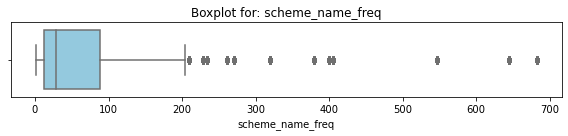

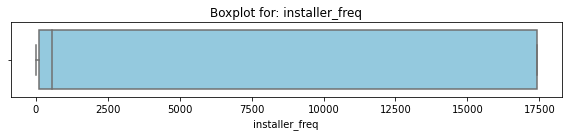

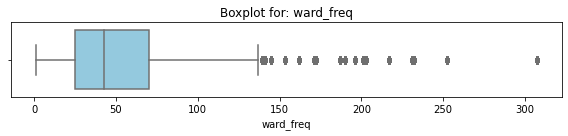

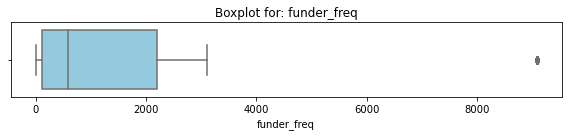

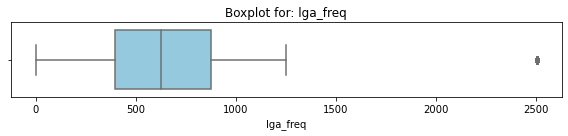

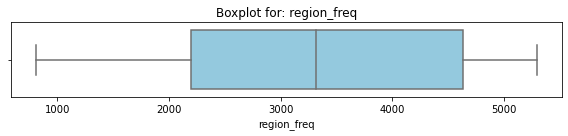

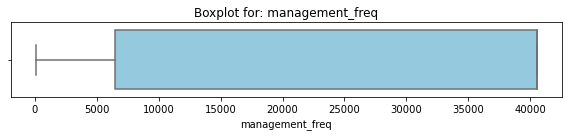

In [51]:
# Loop and plot boxplot for each column
for col in numeric_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df_train_cleaned[col], color='skyblue')
    plt.title(f'Boxplot for: {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

## Detect Outliers (Statistical Methods)

In [52]:
# Cap Outliers Using IQR and Flag Them
def cap_outliers_iqr(df, column):
    # Backup original values
    df[f'{column}_before_clip'] = df[column]

# Calculates lower and upper bounds for acceptable values using IQR
    # Calculate IQR bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Flag which values were outliers
    df[f'{column}_was_outlier'] = (df[column] < lower) | (df[column] > upper)

    # Apply clipping
    df[column] = df[column].clip(lower, upper)

    print(f"{column}: Capped outliers outside [{lower:.2f}, {upper:.2f}]")
    return df

# Apply to selected columns
columns_to_cap = ['amount_tsh', 'population', 'gps_height','longitude', 'latitude']

for col in columns_to_cap:
    df_train_cleaned = cap_outliers_iqr(df_train_cleaned, col)

amount_tsh: Capped outliers outside [-30.00, 50.00]
population: Capped outliers outside [-322.50, 537.50]
gps_height: Capped outliers outside [-1978.88, 3298.12]
longitude: Capped outliers outside [26.96, 43.31]
latitude: Capped outliers outside [-16.36, 4.50]


In [53]:
print("Filtering rows with valid GPS coordinates within Tanzania")

# Define valid bounds
valid_longitude = (df_train_cleaned['longitude'] > 29) & (df_train_cleaned['longitude'] < 41)
valid_latitude = (df_train_cleaned['latitude'] > -12) & (df_train_cleaned['latitude'] < -1)

# Keep only rows within the valid GPS bounding box
df_train_cleaned = df_train_cleaned[valid_longitude & valid_latitude]

print(f"Remaining rows after filtering: {len(df_train_cleaned)}")

Filtering rows with valid GPS coordinates within Tanzania
Remaining rows after filtering: 57581


In [54]:
# Sanity check for any outliers that remain
print(df_train_cleaned['longitude'].min(), df_train_cleaned['longitude'].max())
print(df_train_cleaned['latitude'].min(), df_train_cleaned['latitude'].max())

29.6071219 40.34519307
-11.64944018 -1.00058519


In [55]:
def show_before_after(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 2))
    sns.boxplot(x=df_train_cleaned[f"{col}_before_clip"], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Before Clipping: {col}')
    sns.boxplot(x=df_train_cleaned[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'After Clipping: {col}')
    for ax in axes:
        ax.grid(True)
        ax.set_xlabel('')
    plt.tight_layout()
    plt.show()


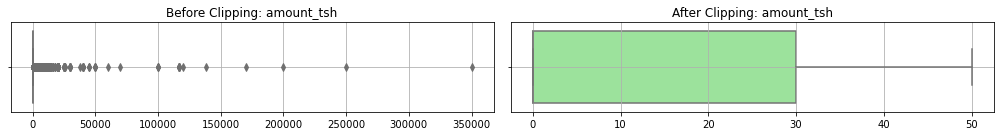

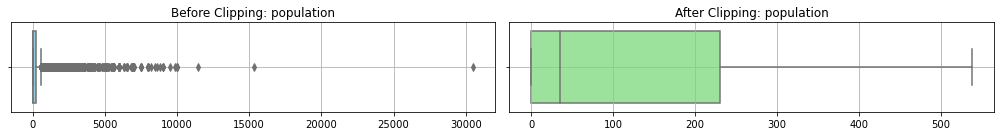

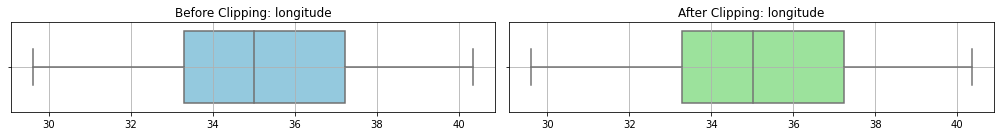

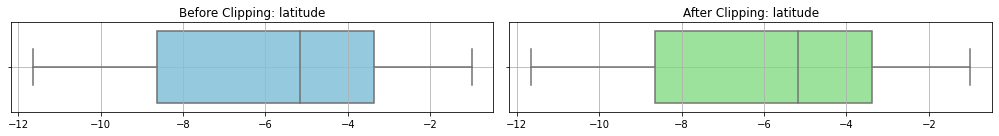

In [56]:
show_before_after('amount_tsh')
show_before_after('population')
show_before_after('longitude')
show_before_after('latitude')

# Normalize / Standardize Numerical Features
th goal is to make sure all the numerical features are on the same scale.

In [57]:
# Select Numeric Columns to Scale
columns_to_scale = ['amount_tsh', 'population', 'gps_height']

In [58]:
# Apply StandardScaler
scaler = StandardScaler()
df_train_cleaned[columns_to_scale] = scaler.fit_transform(df_train_cleaned[columns_to_scale])
print(df_train_cleaned[columns_to_scale].describe().T)

              count          mean       std       min       25%       50%  \
amount_tsh  57581.0  3.305893e-16  1.000009 -0.620930 -0.620930 -0.620930   
population  57581.0  5.815926e-16  1.000009 -0.749541 -0.749541 -0.551521   
gps_height  57581.0 -6.818286e-16  1.000009 -1.123782 -0.994017 -0.379793   

                 75%       max  
amount_tsh  0.795500  1.739787  
population  0.551731  2.291474  
gps_height  0.926513  2.999878  


<ipython-input-58-07ff07100729>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cleaned[columns_to_scale] = scaler.fit_transform(df_train_cleaned[columns_to_scale])
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [59]:
# save the scaler
joblib.dump(scaler, '../data/processed/standard_scaler.pkl')

['../data/processed/standard_scaler.pkl']

Tip: Numerical features were scaled using StandardScaler to normalize magnitudes and improve model convergence. 

# Build a Data Cleaning Pipeline

In [60]:
# Define the IQRClipper
class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds = {}

    def fit(self, X, y=None):
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds[col] = (lower, upper)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            lower, upper = self.bounds[col]
            X[col] = X[col].clip(lower, upper)
        return X

In [61]:
numeric_features = df_train_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_train_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
boolean_features = df_train_cleaned.select_dtypes(include=['bool']).columns.tolist()

In [62]:
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)
print("Boolean Features:", boolean_features)

Numeric Features: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'wpt_name_freq', 'subvillage_freq', 'scheme_name_freq', 'installer_freq', 'ward_freq', 'funder_freq', 'lga_freq', 'region_freq', 'management_freq', 'amount_tsh_before_clip', 'population_before_clip', 'gps_height_before_clip', 'longitude_before_clip', 'latitude_before_clip']
Categorical Features: ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type_class', 'management', 'management_group', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 'status_group']
Boolean Features: ['public_meeting', 'permit', 'quantity_match', 'extraction_mismatch', 'amount_tsh_was_outlier', 'population_was_outlier', 'gps_height_was_outlier', 'longitude_was_outlier', 'latitude_was_outlier']


In [63]:
# define the pipelines

# Numeric preprocessing
numeric_pipeline = Pipeline([
    ('iqr_clip', IQRClipper(columns=numeric_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Boolean preprocessing (optional: cast to int or handle as-is)
boolean_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


In [64]:
# combine into full preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features),
    ('bool', boolean_pipeline, boolean_features)
])

In [65]:
# wrap the final pipeline 
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [66]:
# save the pipeline for later use
joblib.dump(final_pipeline, '../data/processed/data_cleaning_pipeline.pkl')


['../data/processed/data_cleaning_pipeline.pkl']

In [67]:
print(df_train_cleaned.columns.tolist())

['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type_class', 'management', 'management_group', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source_type', 'source_class', 'waterpoint_type', 'status_group', 'quantity_match', 'extraction_mismatch', 'wpt_name_freq', 'subvillage_freq', 'scheme_name_freq', 'installer_freq', 'ward_freq', 'funder_freq', 'lga_freq', 'region_freq', 'management_freq', 'amount_tsh_before_clip', 'amount_tsh_was_outlier', 'population_before_clip', 'population_was_outlier', 'gps_height_before_clip', 'gps_height_was_outlier', 'longitude_before_clip', 'longitude_was_outlier', 'latitude_before_clip', 'latitude_was_outlier']


In [68]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_features)
])

In [69]:
print(final_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iqr_clip',
                                                                   IQRClipper(columns=['amount_tsh',
                                                                                       'gps_height',
                                                                                       'longitude',
                                                                                       'latitude',
                                                                                       'population',
                                                                                       'wpt_name_freq',
                                                                                       'subvillage_freq',
                                                                                       'scheme_name_freq',
            

In [70]:
from sklearn import set_config
set_config(display='diagram')
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iqr_clip',
                                                                   IQRClipper(columns=['amount_tsh',
                                                                                       'gps_height',
                                                                                       'longitude',
                                                                                       'latitude',
                                                                                       'population',
                                                                                       'wpt_name_freq',
                                                                                       'subvillage_freq',
                                                                                       'scheme_name_freq',
                                                                                       'installer_freq',
                                                                                       'ward_freq',
                                                                                       'funder_freq',
                                                                                       'lga_freq',
                                                                                       'region_freq',
                                                                                       'management_freq'])),
                                                                  ('imputer',
                                                                   SimpleImputer(st...
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'source_class',
                                                   'waterpoint_type',
                                                   'status_group']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['public_meeting', 'permit',
                                                   'quantity_match',
                                                   'extraction_mismatch',
                                                   'amount_tsh_was_outlier',
                                                   'population_was_outlier',
                                                   'gps_height_was_outlier',
                                                   'longitude_was_outlier',
                                                   'latitude_was_outlier'])]))])

In [71]:
# Save the cleaned data to CSV
df_train_cleaned.to_csv("../data/processed/cleaned_merged_data.csv", index=False)
print("Cleaned dataset saved successfully to: ../data/processed/cleaned_merged_data.csv")

Cleaned dataset saved successfully to: ../data/processed/cleaned_merged_data.csv
